In [1]:
import pandas as pd
import numpy as np

import mne
from mne.time_frequency import psd_welch

import helper as helper #custom

# visualization stuff
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# 1. Import Data

In [2]:
df = pd.read_csv('data/ssvep-20trials-3s-chaky-bigsquare.csv')

In [3]:
df.shape #check the size of 0

(62436, 10)

In [4]:
print(df[df.Marker==2].shape) #10hz
print(df[df.Marker==1].shape) #6hz
#df.loc[df.Marker==3].index
#df = df.drop(df.loc[df.Marker == 3].index)
print(df[df.Marker==3].shape) #15hz

(20, 10)
(20, 10)
(20, 10)


df.rename(columns={'Unnamed: 1':'Fp1',
                          'Unnamed: 2':'Fp2',
                          'Unnamed: 3':'F3',
                          'Unnamed: 4':'F4'}, 
                 inplace=True)

In [5]:
df.rename(columns={'Unnamed: 1':'O1',
                          'Unnamed: 2':'Oz',
                          'Unnamed: 3':'O2'
                      }, 
                 inplace=True)

In [6]:
df.head()

,timestamps,O1,Oz,O2,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Marker
0,62389.150,38956.250,27233.611,44154.887,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
1,62389.150,39004.645,27278.182,44197.668,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
2,62389.151,39005.805,27278.383,44199.301,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
3,62389.152,38978.270,27251.068,44177.395,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
4,62389.152,38944.137,27219.082,44149.145,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0


In [7]:
df = df.drop(["timestamps", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"], axis=1)

df = df.drop(["timestamps"], axis=1)

In [8]:
df.head()

,O1,Oz,O2,Marker
0,38956.250,27233.611,44154.887,0
1,39004.645,27278.182,44197.668,0
2,39005.805,27278.383,44199.301,0
3,38978.270,27251.068,44177.395,0
4,38944.137,27219.082,44149.145,0


# 2. Transform Data into Raw MNE object

Creating RawArray with float64 data, n_channels=4, n_times=62436
    Range : 0 ... 62435 =      0.000 ...   249.740 secs
Ready.
Effective window size : 8.192 (s)


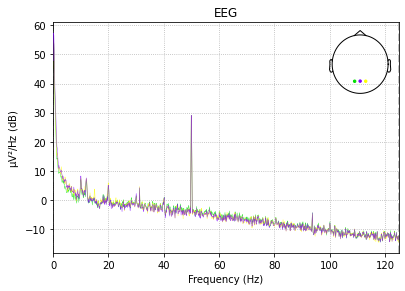

In [9]:
raw = helper.df_to_raw(df)

# 3. Preprocessing

## Notch Filter

Some artifacts are restricted to certain frequencies and can therefore be fixed by filtering. An artifact that typically affects only some frequencies is due to the power line.

Power-line noise is a noise created by the electrical network. It is composed of sharp peaks at 50Hz (or 60Hz depending on your geographical location). Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz, … (or 120Hz, 180Hz, …).

Remove the 50Hz power line noise in Thailand.  We will also be remove its harmonics, i.e., 100Hz, 150Hz, etc.  Since our signal is 125Hz (250Hz / 2 according to Nyquist Theorem), we shall run the harmonics until 125 Hz.

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Effective window size : 8.192 (s)


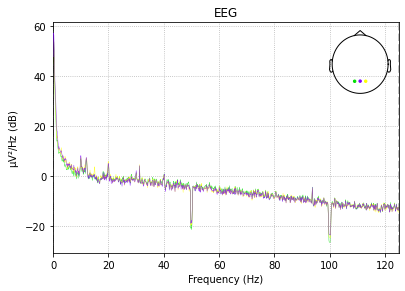

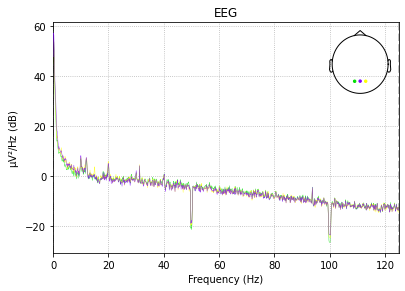

In [10]:
raw.notch_filter(np.arange(50, 125, 50), filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem
#observe that the 50Hz noise is now gone, yay!
raw.plot_psd()

## Band pass filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 16 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 9.00, 16.00 Hz: -6.02, -6.02 dB

Effective window size : 8.192 (s)


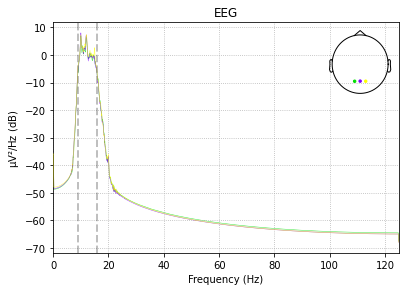

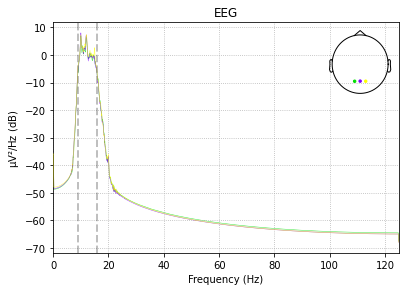

In [11]:
#according to https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0077536,
#the optimal range is 12-18hz

#since we use 6hz, 10hz, and 15hz, 
#thus we probably can observe 10 and 15 but not 6, thus we will take
#harmonic of 6 which is 12
#we will be taking 10-15hz +- 1 = 9,16 to take the tail energy as well

#harmonic of 6 is 18
#harmonic of 10 is 20
#harmonic of 15 is 30
#so it is also possible to take 17 to 31 as another filter and concat
#in this case, we found worst performance, so we only take 9-16

raw.filter(9, 16, method='iir')

#raw1 = raw.copy().filter(9, 16, method='iir')
#raw2 = raw.copy().filter(17, 31, method='iir')
#raw = mne.io.concatenate_raws([raw1, raw2])

raw.plot_psd()

## Independent component analysis

SSVEP is not sensitive against eye artifacts

# 3. Epoching

In [12]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'6Hz': 1, '10Hz' : 2, '15Hz' : 3}
tmin=-0.5
tmax=3
epochs = helper.getEpochs(raw, event_id, tmin, tmax)

60 events found
Event IDs: [1 2 3]
sample drop %:  0.0


## Stimuli-Specific PSD

In [13]:
fig = plt.figure(figsize=(10, 4))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

psd1, freq1 = psd_welch(epochs['6Hz'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['10Hz'], n_fft=1028, n_per_seg=256 * 3)
psd3, freq3 = psd_welch(epochs['15Hz'], n_fft=1028, n_per_seg=256 * 3)

logpsd1 = 10 * np.log10(psd1)
logpsd2 = 10 * np.log10(psd2)
logpsd3 = 10 * np.log10(psd3)

log_psd1_mean = logpsd1.mean(0)
log_psd1_std = logpsd1.mean(0)

log_psd2_mean = logpsd2.mean(0)
log_psd2_std = logpsd2.mean(0)

log_psd3_mean = logpsd3.mean(0)
log_psd3_std = logpsd3.mean(0)

axes.plot(freq1, log_psd1_mean[[0,2], :].mean(0), color='b', label='6Hz')
axes.plot(freq2, log_psd2_mean[[0,2], :].mean(0), color='r', label='10Hz')
axes.plot(freq2, log_psd3_mean[[0,2], :].mean(0), color='g', label='15Hz')

axes.set_title('')
axes.set_ylabel('Power Spectral Density (dB)')
axes.set_xlim(5, 50)
axes.set_ylim(-170, -100)
axes.legend()

Effective window size : 4.112 (s)
Effective window size : 4.112 (s)
Effective window size : 4.112 (s)


Error in callback <function flush_figures at 0x7f3452adff28> (for post_execute):


KeyboardInterrupt: 

# Decoding

In [14]:
import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from mne import Epochs, find_events
from mne.decoding import CSP, Vectorizer, Scaler

from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import Covariances

from collections import OrderedDict
import helper as helper

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

from joblib import dump, load

epochs.pick_types(eeg=True)
X = epochs.get_data() #n_epochs * n_channel * n_time_samples  
y = epochs.events[:, -1]

cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2)

clfs = OrderedDict()

lda = LDA(shrinkage='auto', solver='eigen') #Regularized LDA
svc = OneVsRestClassifier(SVC())
lr = LogisticRegression(multi_class='multinomial')
knn = KNeighborsClassifier(n_neighbors=3) #you would want to optimize
nb = GaussianNB()
rf = RandomForestClassifier(n_estimators=50)
mdm = MDM(metric=dict(mean='riemann', distance='riemann'))
ts = TSclassifier()    
# vec = Vectorizer()    
# scale = Scaler(epoch.info)  #by default, CSP already does this, but if you use Vectorizer, you hve to do it before Vectorizing
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)

# #clfs['Vectorizer + LDA'] = Pipeline([('Scaler', scale), ('Vectorizer', vec), ('Model', lda)])
clfs['CSP + LDA'] = Pipeline([('CSP', csp), ('lda', lda)])
clfs['CSP + SVC'] = Pipeline([('CSP', csp), ('svc', svc)])
clfs['CSP + LR'] = Pipeline([('CSP', csp), ('lr', lr)])
clfs['CSP + KNN'] = Pipeline([('CSP', csp), ('Model', knn)])
clfs['CSP + NB'] = Pipeline([('CSP', csp), ('nb', nb)])
clfs['CSP + RF'] = Pipeline([('CSP', csp), ('rf', rf)])

#https://www.researchgate.net/publication/323358565_Riemannian_Classification_for_SSVEP-Based_BCI_Offline_versus_Online_Implementations
clfs['Cov + MDM'] = Pipeline([('Cov', Covariances('oas')), ('mdm', mdm)]) #oas is needed for non-PD matrix

clfs['Cov + TS'] = Pipeline([('Cov', Covariances('oas')), ('ts', ts)]) #oas is needed for non-PD matrix


auc = []
methods = []
model = clfs['Cov + MDM'].fit(X,y)
print("resultsss",model.predict(X))
print(X.shape)
# for m in clfs:
#     clfs[m].fit(X, y)
#     filename = m + ".joblib"
#     dump(clfs[m], filename)
#     res = cross_val_score(clfs[m], X, y, cv=cv)
#     print(res.mean())
#     auc.extend(res)
#     methods.extend([m]*len(res))
#     model = clfs[m].fit(X,y)
#     print("resultsss",model.predict(X))

    
results = pd.DataFrame(data=auc, columns=['Cross-Validated-Scores'])
results['Method'] = methods  

"""
To use the model,
loaded_model = load(filename.joblib)
loaded_model.predict(X)
"""


resultsss [3 2 3 3 2 3 1 1 3 1 2 3 1 2 3 2 2 3 2 2 3 1 1 3 1 2 1 1 2 3 1 2 3 1 2 3 1
 2 3 1 2 2 1 2 3 1 2 2 1 2 3 1 2 3 1 1 3 1 2 3]
(60, 3, 876)


/home/chaklam/bci_project/bci_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/chaklam/bci_project/bci_env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


'\nTo use the model,\nloaded_model = load(filename.joblib)\nloaded_model.predict(X)\n'

Empty DataFrame
Columns: [Cross-Validated-Scores, Method]
Index: []


ValueError: min() arg is an empty sequence

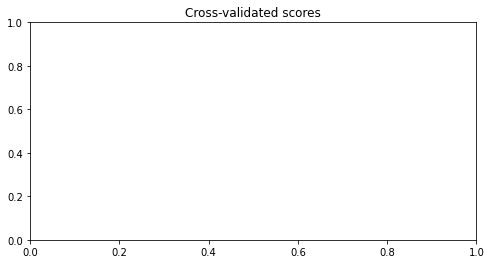

In [15]:
print(results)

figure = plt.figure(figsize=[8,4])
plt.title("Cross-validated scores")
sns.barplot(data=results, x='Cross-Validated-Scores', y='Method')
plt.xlim(0.2, 1)   

# Recurrent Network - LSTM

In [ ]:
import lstmDecoding as lstm
lstm.decode(raw, event_id, tmin, tmax)

# Temporal CNN

In [ ]:
import tcnDecoding as tcn #custom
tcn.decode(raw, event_id, tmin, tmax)

# Spectral Decoding

In [ ]:
import spectralDecoding as spec
spec.decode(raw, event_id, tmin, tmax)

# MNE-Features

In [ ]:
from mne_features.feature_extraction import FeatureExtractor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import helper as helper

X = epochs.get_data()
y = epochs.events[:, -1]

###############################################################################
# Prepare for the classification task:

#for selected funcs params, see the api for alias
#read more here -> https://mne.tools/mne-features/api.html

#here is the list of features
features = (['app_entropy', 'decorr_time', 'energy_freq_bands', 
            'higuchi_fd', 'hjorth_complexity', 'hjorth_complexity_spect', 
            'hjorth_mobility', 'hjorth_mobility_spect', 'hurst_exp', 
            'katz_fd', 'kurtosis', 'line_length', 'mean', 'pow_freq_bands', 
            'ptp_amp', 'samp_entropy', 'skewness', 'spect_edge_freq', 
            'spect_entropy', 'spect_slope', 'std', 'svd_entropy', 
            'svd_fisher_info', 'teager_kaiser_energy', 'variance', 
            'wavelet_coef_energy', 'zero_crossings', 'max_cross_corr', 
            'nonlin_interdep', 'phase_lock_val', 'spect_corr', 'time_corr'])

#if you prefer to loop through all features

for feature in features:    
    pipe = Pipeline([('fe', FeatureExtractor(sfreq=raw.info['sfreq'],
                                         selected_funcs= [feature])),  #comment out if you want to try to see all features
                 ('scaler', StandardScaler()),
                 ('clf', LogisticRegression(random_state=None, solver='lbfgs'))])
    cv = StratifiedKFold(n_splits=5, random_state=None)
    scores = cross_val_score(pipe, X, y, cv=cv)
    print('Cross-validation accuracy score (with ' +  feature + ') = %1.3f '
      '(+/- %1.5f)' % (np.mean(scores), np.std(scores)))